# Kullanacağımız Kütüphaneleri Yüklüyoruz

In [1]:
import pandas as pd 
import numpy as np 
import random
import os 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from pathlib import Path
from PIL import Image

import tensorflow as tf
import struct
import warnings
warnings.filterwarnings('ignore')

# Veri Setini Çekme

In [2]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':
            if dir_name.split()[-1]!='GT':                       
                label.append(os.path.split(dir_name)[-1])         
                path.append(os.path.join(dir_name,filename))     

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label
data.head(5)

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


Veri Seti Hakkında Bilgileri Gözlemliyoruz


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [4]:
data.isnull().sum()

path     0
label    0
dtype: int64

In [5]:
#hangi türden ne kadar olduğunu gözlemliyoruz
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

Pasta graifği ile veri setininde ki etikelerin oranlarını gözlemliyoruz


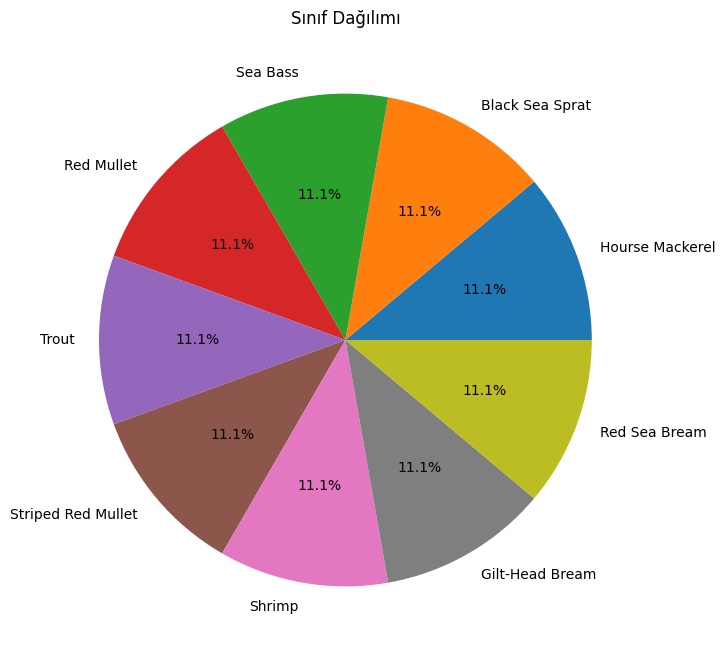

In [6]:
#pasta grafik 
# Sınıf dağılımını hesaplayalım
class_distribution = data['label'].value_counts()

# Pasta grafik
class_distribution.plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Sınıf Dağılımı')
plt.ylabel('')  # Y etiketini gizlemek için
plt.show()

In [7]:
data['label'].unique()

array(['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet',
       'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream',
       'Red Sea Bream'], dtype=object)

# Veri Ön İşlem


In [8]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Hedef değişkenleri kodlama
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

YVB Fonksiyonu
* Resimleri yükleme ve boyutlandırma fonksiyonu
* Bu fonksiyon, veri çerçevesinde belirtilen resim dosyalarını verilen boyutlara göre yükler,
* Her bir resmi normalleştirir (0-1 aralığına getirir) ve numpy dizisi olarak geri döner.


In [9]:
# Resimleri yükleme ve boyutlandırma fonksiyonu
def yvb(df, target_size=(224, 224)):
    images = []
    for img_path in df['path']:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalizasyon
        images.append(img_array)
    return np.array(images)

# Eğitim ve test resimlerini yükleme
X_train = yvb(train_df)
X_test = yvb(test_df)

# Hedef değişkenleri
y_train = train_df['label'].values
y_test = test_df['label'].values


Veri arttırma tekniğini kullanrak verilerimizin çeşitlendiriyoruz

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation ayarları
datagen = ImageDataGenerator(
    rotation_range=20,      # 20 dereceye kadar rastgele döndürme
    width_shift_range=0.2,  # Genişlik boyunca rastgele kaydırma
    height_shift_range=0.2, # Yükseklik boyunca rastgele kaydırma
    shear_range=0.2,        # Rastgele kesme
    zoom_range=0.2,         # Rastgele zoom
    horizontal_flip=True,   # Rastgele yatay çevirme
    fill_mode='nearest'     # Dolgu modu
)

# Eğitim verisini artırarak kullanma
datagen.fit(X_train)


In [11]:
# Train ve test setlerin boyutlarını görüntüleyelim.
print(f'X_train setinin boyutu: {X_train.shape}')
print(f'X_test setinin boyutu: {X_test.shape}')

print(f'y_train setinin boyutu: {y_train.shape}')
print(f'y_test setinin boyutu: {y_test.shape}')




X_train setinin boyutu: (7200, 224, 224, 3)
X_test setinin boyutu: (1800, 224, 224, 3)
y_train setinin boyutu: (7200,)
y_test setinin boyutu: (1800,)


Veri setinden rastgele 16 tane veriyi çekip etiketleri ile birlikte gözlemliyoruz

<Figure size 1200x1200 with 0 Axes>

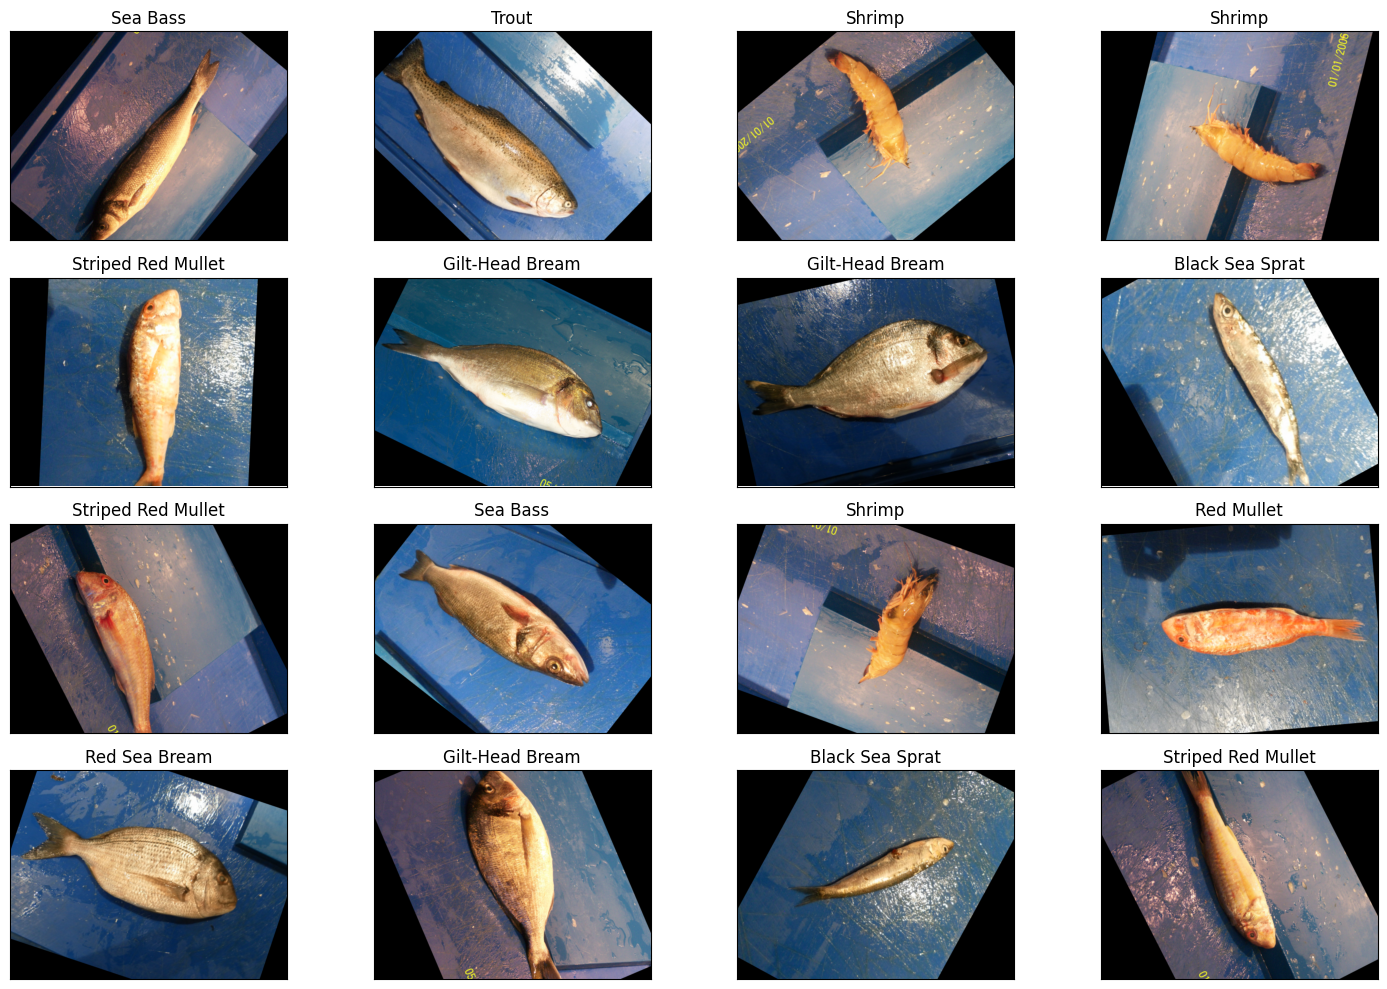

In [12]:
#16 tane örnek veriye gözlemliyoruz
def plot_images(data, num_images=16):
    plt.figure(figsize=(12, 12))
    # Rastgele num_images kadar örnek seç
    random_indices = random.sample(range(len(data)), num_images)
    
    # 4x4 grid düzeni
    fix, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10),
                             subplot_kw={'xticks': [], 'yticks': []})
    
    for i, ax in enumerate(axes.flat):
        # Seçilen rastgele indekslere göre görüntü ve etiket
        idx = random_indices[i]
        image_path = data.iloc[idx]['path']
        label = data.iloc[idx]['label']
        image = plt.imread(image_path)
        
        # Görüntüyü ve etiketi her bir hücreye yerleştir
        ax.imshow(image)
        ax.set_title(label)
        
    plt.tight_layout()
    plt.show()

# 16 görüntü ve etiket görüntüleme
plot_images(data, num_images=16)

# Model Oluşturma

In [13]:
# Modeli oluşturma
model = Sequential()
#giriş katmaını
model.add(Flatten(input_shape=(224, 224, 3)))  # Resim boyutunu düzleştirme

#gizli katmanlar
model.add(Dense(512, activation='relu'))  
model.add(Dropout(0.075))

model.add(Dense(256, activation='relu'))  

model.add(Dense(128, activation='relu'))


#çıkış katmanı
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Sınıf sayısı kadar çıkış 

#Model Derlemesi 
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik (doğrulama kaybı)
    patience=5,          #  val_loss iyileşmezse 3 epoch sonra durdur
    restore_best_weights=True,  # En iyi modelin ağırlıklarını geri yükle
    verbose=1            # Durum güncellemelerini yazdır
)

In [15]:
# Modeli eğitme aşaması
history = model.fit(X_train, y_train, epochs=20,batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/20


I0000 00:00:1729689735.520629      73 service.cc:145] XLA service 0x790ad4003300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729689735.520711      73 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729689735.520717      73 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  7/225 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1362 - loss: 39.4426

I0000 00:00:1729689738.706301      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.2365 - loss: 13.7246 - val_accuracy: 0.4650 - val_loss: 1.5004
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.4694 - loss: 1.5072 - val_accuracy: 0.5461 - val_loss: 1.1940
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5940 - loss: 1.1400 - val_accuracy: 0.6922 - val_loss: 0.9152
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6547 - loss: 0.9878 - val_accuracy: 0.6633 - val_loss: 0.9578
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7049 - loss: 0.8396 - val_accuracy: 0.7667 - val_loss: 0.6958
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7391 - loss: 0.7349 - val_accuracy: 0.7722 - val_loss: 0.6688
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7350 - loss: 0.7590 - val_accuracy: 0.7611 - val_loss: 0.6933
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7294 - loss: 0.7659 - val_accuracy: 0.8

# Sonuçları Grafikler ve Sayısal Değerler İle Değerlendiriyoruz


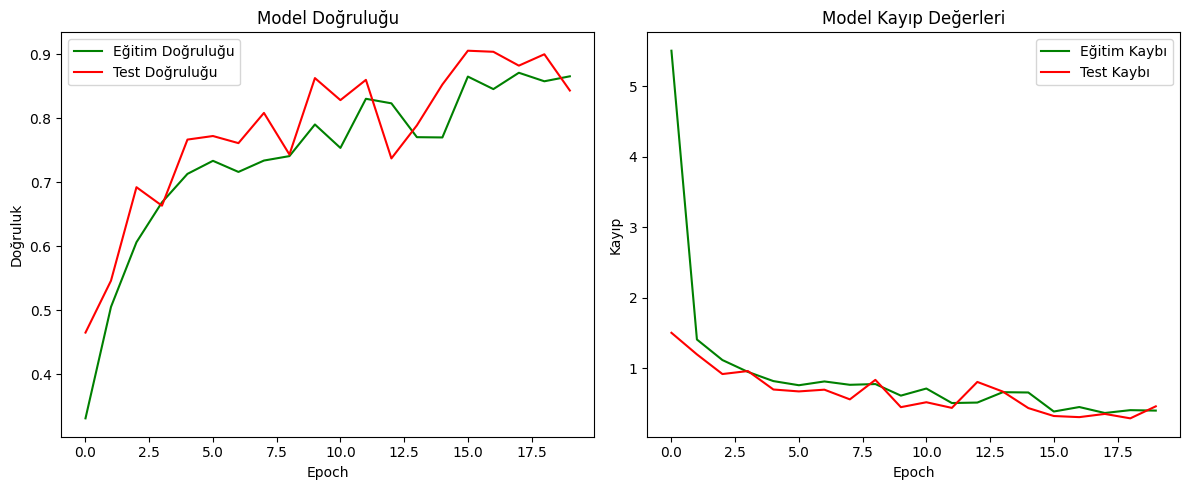

In [16]:
# Eğitim sonuçlarını görselleştirelim
plt.figure(figsize=(12, 5)) 

#accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu',color ='green')
plt.plot(history.history['val_accuracy'], label='Test Doğruluğu',color = 'red')
plt.title('Model Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend()


#loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı',color ='green')
plt.plot(history.history['val_loss'], label='Test Kaybı',color = 'red')
plt.title('Model Kayıp Değerleri')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
plt.legend()


plt.tight_layout()
plt.show()


In [17]:
# Test seti ile tahmin yapalım
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [18]:
# Test seti üzerinde modeli değerlendirelim
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.2867584228515625
Test Accuracy: 0.8999999761581421


In [19]:
from sklearn.metrics import f1_score
# F1 skoru hesapla
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.90


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


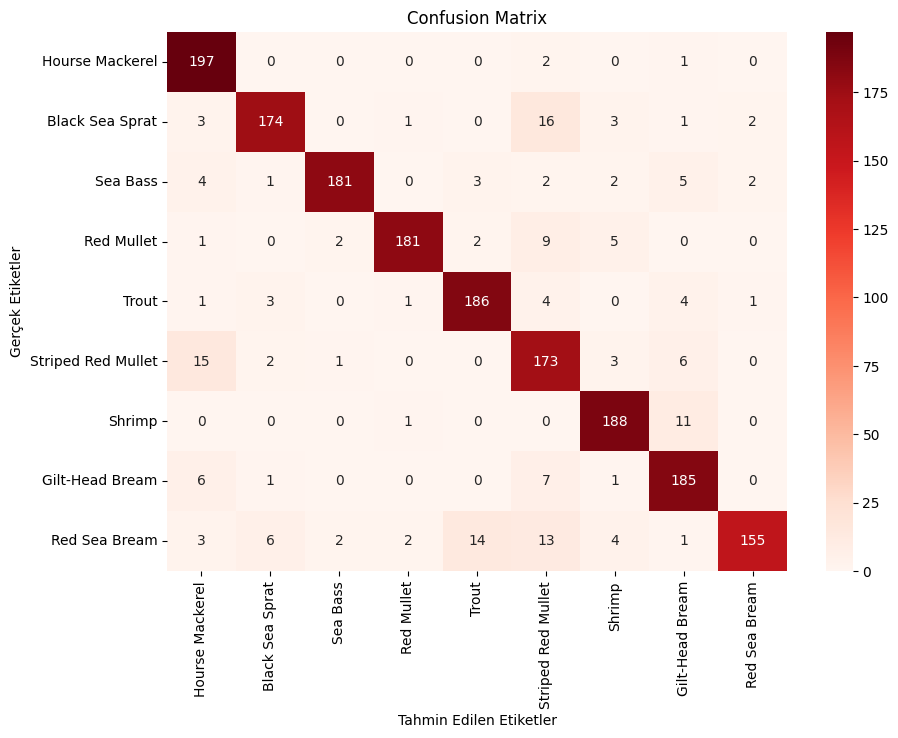

In [20]:
# Gerçek ve tahmin edilen etiketler
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

# Etiket isimleri
labels = ['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet',
          'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream',
          'Red Sea Bream']

# Grafikleştirme
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)

# Başlık ve etiketler
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Edilen Etiketler')

plt.show()